# Early-Stage Alzheimer's Disease Prediction Using Machine Learning Models

## Kreativno proširenje članka

[ISTRAŽIVAČKI RAD](https://www.frontiersin.org/articles/10.3389/fpubh.2022.853294/full#B21)  

### 1. Učitavanje podataka

Budući da smo u fazi replikacije rezultata u skupu podataka koristili samo prve snimke svakog pacijenta u ovom proširenju razmatramo kako se neki modeli ponašaju na skupu podataka koji sadrži samo prve snimke i na skupu podataka koji sadrži sve snimke

In [22]:
### Uvoz potrebnih biblioteka
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
X = pd.read_csv("dataset/oasis_longitudinal.csv")
X.shape

(373, 15)

In [24]:
X.head(7)

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034
5,OAS2_0004,OAS2_0004_MR1,Nondemented,1,0,F,R,88,18,3.0,28.0,0.0,1215,0.710,1.444
6,OAS2_0004,OAS2_0004_MR2,Nondemented,2,538,F,R,90,18,3.0,27.0,0.0,1200,0.718,1.462


#### 1.1. Podaci samo sa prvim snimanjem

In [25]:
X_firstScan = X.loc[X['MRI ID'].str.contains("_MR1"), :]

Iz prethodnog rada na skupu podataka znamo da značajke:
- Subject ID
- MRI ID
- Hand
- MR Delay
- Visit

ne donose korisnu informaciju na skupu podataka koji koristi samo prve snimke pacijenata.

Značajku Group izbacujemo zbog nejase interpretacije te značajke u polaznom radu. Tu značajku konstruirat ćemo iz značajke CDR, ako je ta vrijednost veća od 0 vrijednost grupe postavljamo na Demented, a inače na Nondemented

In [26]:
X_firstScan = X_firstScan.drop(columns=['Subject ID', 'MRI ID', 'Hand', 'Visit', 'MR Delay'])
X_firstScan

,Group,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,Nondemented,M,87,14,2.0,27.0,0.0,1987,0.696,0.883
2,Demented,M,75,12,NaN,23.0,0.5,1678,0.736,1.046
5,Nondemented,F,88,18,3.0,28.0,0.0,1215,0.710,1.444
7,Nondemented,M,80,12,4.0,28.0,0.0,1689,0.712,1.039
10,Demented,M,71,16,NaN,28.0,0.5,1357,0.748,1.293
...,...,...,...,...,...,...,...,...,...,...
359,Demented,M,73,12,NaN,23.0,0.5,1661,0.698,1.056
361,Nondemented,F,66,13,2.0,30.0,0.0,1495,0.746,1.174
365,Demented,F,72,16,3.0,24.0,0.5,1354,0.733,1.296
367,Demented,M,80,16,1.0,28.0,0.5,1704,0.711,1.030


In [27]:
# Creating Custom Group 
X_firstScan.loc[X_firstScan['CDR'] == 0, 'Custom Group'] = 0
X_firstScan.loc[X_firstScan['CDR'] > 0, 'Custom Group'] = 1
X_firstScan = X_firstScan.drop(columns = ['Group'])

**Custom Group**:
- 0 => "Nondemented"
- 1 => "Demented"


Sljedeći korak je pretvorba kategoričke varijable 'M/F' pomoću LabelEncodera.

In [28]:
from sklearn.preprocessing import LabelEncoder

# Transforming M/F variable
leMF = LabelEncoder()
leMF.fit(X_firstScan.loc[:, 'M/F'])
X_firstScan.loc[:, 'M/F'] = leMF.transform(X_firstScan.loc[:, 'M/F'])

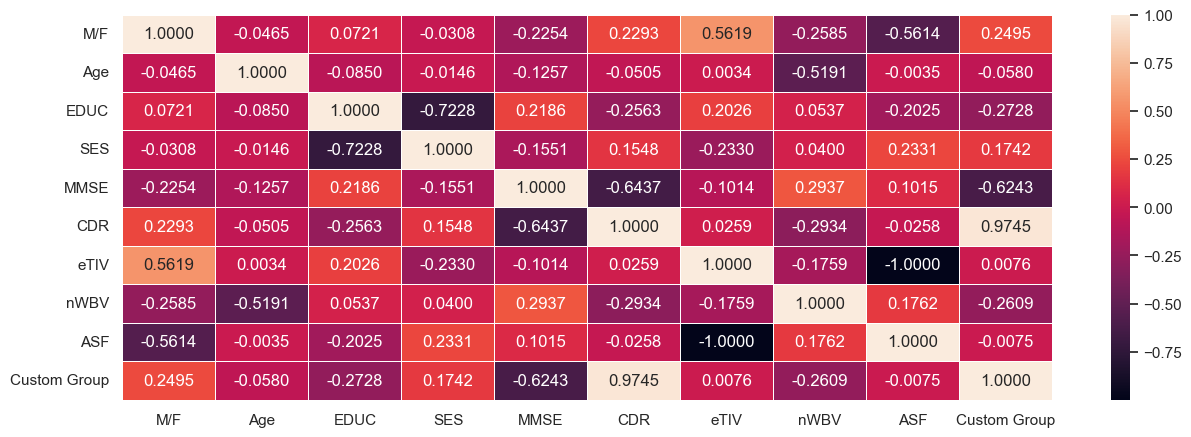

In [29]:
corr_matrix = X_firstScan.corr(method='spearman')
sns.set(rc={'figure.figsize':(15,5)})
sns.heatmap(corr_matrix, annot=True, fmt=".4f", linewidths=0.5)
plt.show()

Iz prikazane matrice korelacije vidljivo je da su jako korelirani sljedeći parovi značajki:
- SES i EDUC
- ASF i eTIV

Korelacija između socioekonomskog statusa i obrazovanja nekako proizlazi iz stvarnog svijeta. Logično je da će obrazovanija osoba biti većeg socioekonomskog statusa.

Korelacija između značajki ASF i eTIV proizlazi iz činjenice da se ASF vrijednost računa iz eTIV vrijednosti.  

Ove značajke zasad neće biti uklonjene iz skupa podataka, no kod odabira i treniranja modela strojnog učenja treba imati na umu da su ovi parovi značajka međusobno korelirani.

Iz gornje matrice vidljivo je da su značajke SES i EDUC snažno korelirane. Iz tog razloga nedostajuće vrijednosti značajke SES nadopuniti srednjom vrijednošću podataka, ali grupiranih prema značajki EDUC.

**Napomena** : Iz gornjeg ispisa nedostajućih vrijednosti zaključujemo da je dovoljno vidjeti koje su srednje vrijednosti za grupe sa vrijednostima značajke EDUC 12 i 16.  
**Napomena**: Kako je SES kategorička varijabla računat ćemo medijan.

In [30]:
educ_ses=X_firstScan[['EDUC', 'SES']].groupby(['EDUC'], as_index=False).median()
X_firstScan.loc[(X_firstScan['EDUC'] == 12) & (X_firstScan['SES'].isna()), 'SES'] = educ_ses.loc[educ_ses['EDUC'] == 12, 'SES'].values[0]
X_firstScan.loc[(X_firstScan['EDUC'] == 16) & (X_firstScan.SES.isna()), 'SES'] = educ_ses.loc[educ_ses['EDUC'] == 16, 'SES'].values[0]

Iz prethodnog rada nad ovim skupom znamo da u ovom skupom postoje stršeći podaci, ali njih nije potrebno uklanjati jer ih je malo, ne izlaze iz očekivanog intervala vrijednosti značajki i jer su interpretabilni u kontekstu semantike značajke.

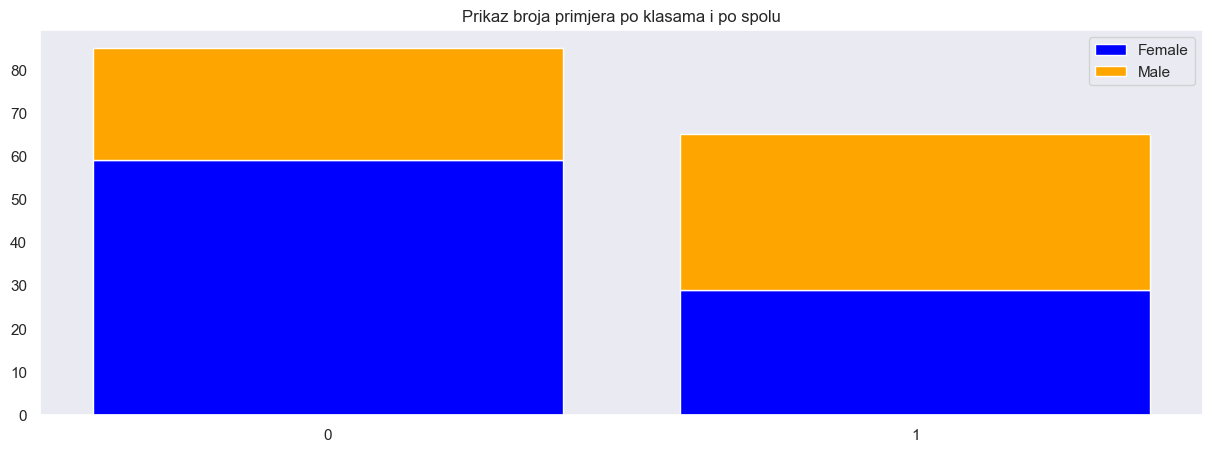

In [31]:
X_vis = X_firstScan.copy()
count_per_group_male = X_vis.loc[X_vis['M/F'] == 1, :].groupby('Custom Group').count().loc[:, 'EDUC'].values
count_per_group_female = X_vis.loc[X_vis['M/F'] == 0, :].groupby('Custom Group').count().loc[:, 'EDUC'].values
group_names = X_vis.groupby('Custom Group').count().index.values

# plot
plt.bar(group_names, count_per_group_female, color='blue', label='Female')
plt.bar(group_names, count_per_group_male, color='orange', label='Male', bottom = count_per_group_female)

plt.title('Prikaz broja primjera po klasama i po spolu')
plt.legend(loc='best')
plt.xticks(np.arange(0, 2, 1))
plt.grid()
plt.show()

####  1.2. Podaci sa svim snimkama

In [32]:
X = pd.read_csv("dataset/oasis_longitudinal.csv")
X.shape

(373, 15)

In [33]:
X_allscans = X.copy()
X_allscans = X_allscans.drop(columns=['Hand', 'MRI ID'])
X_allscans

,Subject ID,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,Nondemented,1,0,M,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,Nondemented,2,457,M,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,Demented,1,0,M,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,Demented,2,560,M,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,Demented,3,1895,M,80,12,NaN,22.0,0.5,1698,0.701,1.034
...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,OAS2_0185,Demented,2,842,M,82,16,1.0,28.0,0.5,1693,0.694,1.037
369,OAS2_0185,Demented,3,2297,M,86,16,1.0,26.0,0.5,1688,0.675,1.040
370,OAS2_0186,Nondemented,1,0,F,61,13,2.0,30.0,0.0,1319,0.801,1.331
371,OAS2_0186,Nondemented,2,763,F,63,13,2.0,30.0,0.0,1327,0.796,1.323


Pretvorba kategoričke varijable 'M/F' i konstrukcija značajke 'Custom Group'

In [34]:
# Transforming M/F variable
leMF = LabelEncoder()
leMF.fit(X_allscans.loc[:, 'M/F'])
X_allscans.loc[:, 'M/F'] = leMF.transform(X_allscans.loc[:, 'M/F'])

# Creating Custom Group 
X_allscans.loc[X_allscans['CDR'] == 0, 'Custom Group'] = 0
X_allscans.loc[X_allscans['CDR'] > 0, 'Custom Group'] = 1


X_allscans = X_allscans.drop(columns=['Group'])
X_allscans.head(10)

,Subject ID,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,Custom Group
0,OAS2_0001,1,0,1,87,14,2.0,27.0,0.0,1987,0.696,0.883,0.0
1,OAS2_0001,2,457,1,88,14,2.0,30.0,0.0,2004,0.681,0.876,0.0
2,OAS2_0002,1,0,1,75,12,NaN,23.0,0.5,1678,0.736,1.046,1.0
3,OAS2_0002,2,560,1,76,12,NaN,28.0,0.5,1738,0.713,1.010,1.0
4,OAS2_0002,3,1895,1,80,12,NaN,22.0,0.5,1698,0.701,1.034,1.0
5,OAS2_0004,1,0,0,88,18,3.0,28.0,0.0,1215,0.710,1.444,0.0
6,OAS2_0004,2,538,0,90,18,3.0,27.0,0.0,1200,0.718,1.462,0.0
7,OAS2_0005,1,0,1,80,12,4.0,28.0,0.0,1689,0.712,1.039,0.0
8,OAS2_0005,2,1010,1,83,12,4.0,29.0,0.5,1701,0.711,1.032,1.0
9,OAS2_0005,3,1603,1,85,12,4.0,30.0,0.0,1699,0.705,1.033,0.0


In [35]:
### Changing Subject ID from format OAS2_id to just id
X_allscans['Subject ID'] = X_allscans['Subject ID'].str.extract(r'OAS2_(\d+)')
X_allscans['Subject ID'] = pd.to_numeric(X_allscans['Subject ID'], errors='coerce')

In [36]:
X_allscans

,Subject ID,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,Custom Group
0,1,1,0,1,87,14,2.0,27.0,0.0,1987,0.696,0.883,0.0
1,1,2,457,1,88,14,2.0,30.0,0.0,2004,0.681,0.876,0.0
2,2,1,0,1,75,12,NaN,23.0,0.5,1678,0.736,1.046,1.0
3,2,2,560,1,76,12,NaN,28.0,0.5,1738,0.713,1.010,1.0
4,2,3,1895,1,80,12,NaN,22.0,0.5,1698,0.701,1.034,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,185,2,842,1,82,16,1.0,28.0,0.5,1693,0.694,1.037,1.0
369,185,3,2297,1,86,16,1.0,26.0,0.5,1688,0.675,1.040,1.0
370,186,1,0,0,61,13,2.0,30.0,0.0,1319,0.801,1.331,0.0
371,186,2,763,0,63,13,2.0,30.0,0.0,1327,0.796,1.323,0.0


##### 1.2.1. Nedostajuće vrijednosti

In [40]:
print(X_allscans.shape)
X_allscans.isna().sum()

(373, 13)


Subject ID       0
Visit            0
MR Delay         0
M/F              0
Age              0
EDUC             0
SES             19
MMSE             2
CDR              0
eTIV             0
nWBV             0
ASF              0
Custom Group     0
dtype: int64

Iz prikazanog vidimo da postoje nedostajuće vrijednosti kod značajki SES i MMSE. Htjeli bismo ih nadomjestiti nekim vrijednostima budući da je skup podataka relativno malen. U tu svrhu pogledajmo korelaciju značajki.

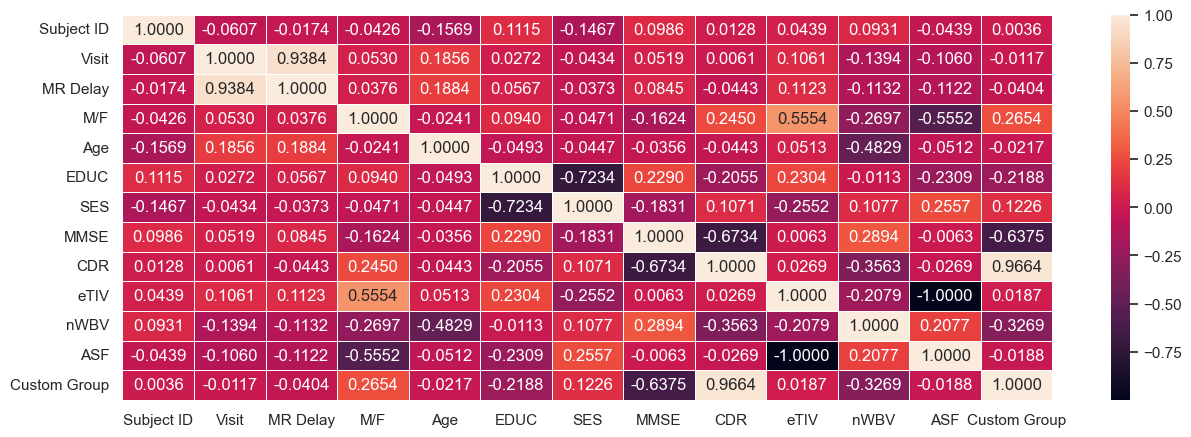

In [41]:
corr_matrix = X_allscans.corr(method='spearman')
sns.set(rc={'figure.figsize':(15,5)})
sns.heatmap(corr_matrix, annot=True, fmt=".4f", linewidths=0.5)
plt.show()

Iz korelacijske matrice vidimo da je varijabla MMSE najviše korelirana s značajkom CDR, a značajka SES sa značajkom EDUC. Sukladno tome značajku MMSE nadomjestit ćemo medijanom nakon grupiranja po CDR-u, a značajku SES medijanom nakon grupiranja po značajki EDUC.

In [44]:
educ_ses=X_allscans[['EDUC', 'SES']].groupby(['EDUC'], as_index=False).median()
print(educ_ses)

mmse_cdr = X_allscans[['MMSE', 'CDR']].groupby(['CDR'], as_index=False).median()
print("\n")
print(mmse_cdr)

    EDUC  SES
0      6  4.0
1      8  5.0
2     11  4.0
3     12  3.0
4     13  2.0
5     14  3.0
6     15  2.0
7     16  2.0
8     17  1.0
9     18  2.0
10    20  1.0
11    23  1.0


   CDR  MMSE
0  0.0  29.0
1  0.5  27.0
2  1.0  21.0
3  2.0  21.0


In [45]:
X_allscans.loc[X_allscans.SES.isna(), :]

,Subject ID,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,Custom Group
2,2,1,0,1,75,12,NaN,23.0,0.5,1678,0.736,1.046,1.0
3,2,2,560,1,76,12,NaN,28.0,0.5,1738,0.713,1.010,1.0
4,2,3,1895,1,80,12,NaN,22.0,0.5,1698,0.701,1.034,1.0
10,7,1,0,1,71,16,NaN,28.0,0.5,1357,0.748,1.293,1.0
11,7,3,518,1,73,16,NaN,27.0,1.0,1365,0.727,1.286,1.0
12,7,4,1281,1,75,16,NaN,27.0,1.0,1372,0.710,1.279,1.0
134,63,1,0,0,80,12,NaN,30.0,0.5,1430,0.737,1.228,1.0
135,63,2,490,0,81,12,NaN,27.0,0.5,1453,0.721,1.208,1.0
207,99,1,0,0,80,12,NaN,27.0,0.5,1475,0.762,1.190,1.0
208,99,2,807,0,83,12,NaN,23.0,0.5,1484,0.750,1.183,1.0


In [46]:
X_allscans.loc[X_allscans.MMSE.isna(), :]

,Subject ID,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,Custom Group
357,181,2,539,0,75,12,NaN,NaN,1.0,1169,0.742,1.501,1.0
358,181,3,1107,0,77,12,NaN,NaN,1.0,1159,0.733,1.515,1.0


Iz gornjeg ispisa vidljivo je da su nedostajuće vrijednosti MMSE u onim grupama gdje je  vrijednost EDUC-a 12 ili 16, dok je MMSE nedostajuća vrijednost u grupi gdje je vrijednost značajke CDR 1.0.

In [60]:
X_allscans.loc[(X_allscans['EDUC'] == 12) & (X_allscans['SES'].isna()), 'SES'] = educ_ses.loc[educ_ses['EDUC'] == 12, 'SES'].values[0]
X_allscans.loc[(X_allscans['EDUC'] == 16) & (X_allscans.SES.isna()), 'SES'] = educ_ses.loc[educ_ses['EDUC'] == 16, 'SES'].values[0]

X_allscans.SES.isna().sum()

0

In [63]:
X_allscans.loc[(X_allscans['CDR'] == 1) & (X_allscans['MMSE'].isna()), 'MMSE'] = mmse_cdr.loc[mmse_cdr['CDR'] == 1, 'MMSE'].values[0]

X_allscans.MMSE.isna().sum()

0

##### 1.2.2. Vizualizacija skupa podataka sa svim snimkama

In [64]:
X_vis = X_allscans.copy()

Udio po spolu

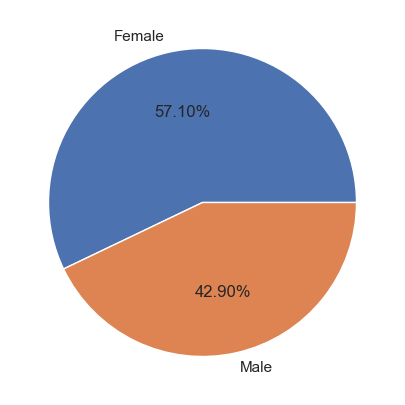

In [65]:
count_per_sex = X_vis.groupby('M/F').count().loc[:, 'Custom Group'].values
names = X_vis.groupby('M/F').count().loc[:, 'Custom Group'].index.values
percent = (count_per_sex/len(X_vis)) * 100

plt.pie(percent, labels=["Female", "Male"], autopct='%.2f%%')
plt.show()

Iz gornjeg grafa vidimo da u skupu podataka prevladavaju snimke mozga ženskog spola sa nekih 57%

Prisutnost Alzheimerove bolesti po spolovima

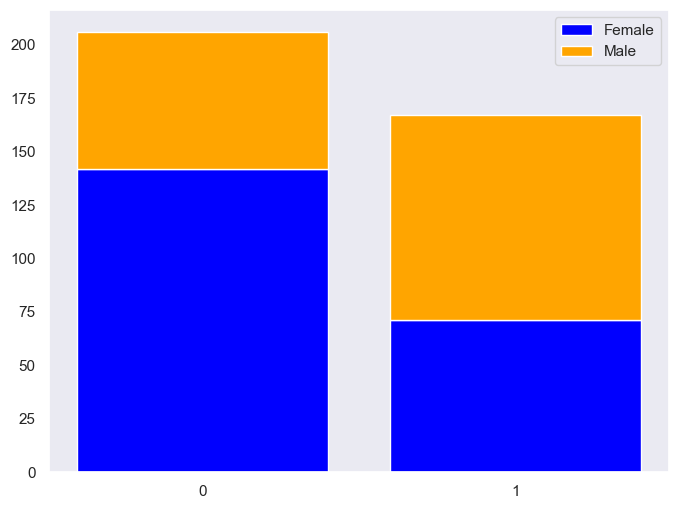

In [77]:
count_per_group_male = X_vis.loc[X_vis['M/F'] == 1, :].groupby('Custom Group').count().loc[:, 'Subject ID'].values
count_per_group_female = X_vis.loc[X_vis['M/F'] == 0, :].groupby('Custom Group').count().loc[:, 'Subject ID'].values
group_names = X_vis.groupby('Custom Group').count().index.values

# plot
plt.figure(figsize=(8,6))
plt.bar(group_names, count_per_group_female, color='blue', label='Female')
plt.bar(group_names, count_per_group_male, color='orange', label='Male', bottom = count_per_group_female)

plt.legend(loc='best')
plt.xticks(np.arange(0, 2, 1))
plt.grid()
plt.show()

Iz gornjeg prikaza možemo zaključiti da je više slika klasificirano kao 'Nondemented'. Također vidljivo je da je u toj klasi više ženskog spola, nego muškog. U klasi 'Demented' veći udio čini muški spol. Sukladno tome možemo naslutiti da ako je pacijent klasificran kao 'Demented' da je vjerojatnije da je muškog, a ne ženskog spola.

Dob

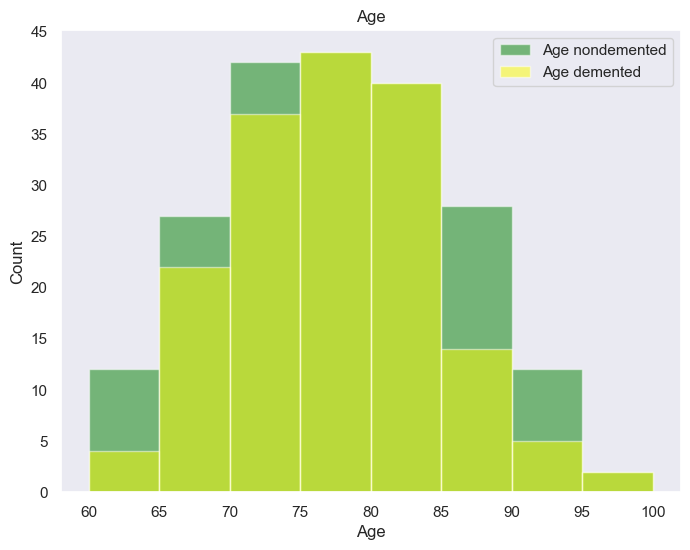

In [76]:
# All data
plt.figure(figsize=(8,6))
plt.title("Age")
plt.hist(X_vis[X_vis['Custom Group'] == 0].Age, bins=8, range=(60,100), alpha=0.5, color='green', label="Age nondemented")
plt.hist(X_vis[X_vis['Custom Group'] == 1].Age, bins=8, range=(60,100), alpha=0.5, color='yellow', label="Age demented")
plt.legend(loc='best')
plt.xlabel('Age')
plt.ylabel('Count')
plt.yticks(np.arange(0,50,5))
plt.grid()



Kognitivne sposobnosti (MMSE)

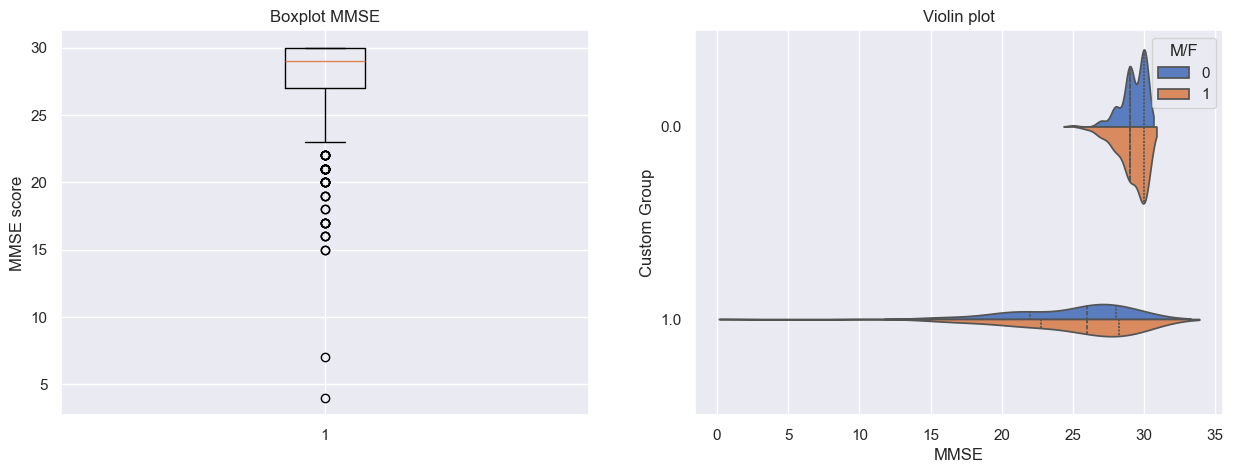

In [69]:
plt.subplot(1,2,1)
plt.boxplot(X_vis.MMSE)
plt.title('Boxplot MMSE')
plt.ylabel('MMSE score')

plt.subplot(1,2,2)
plt.title('Violin plot')
sns.violinplot(x="MMSE", y="Custom Group",hue="M/F" ,orient="h", data=X_vis, palette="muted", split=True, inner="quartile")
plt.show()


Analizom boxplota zaključuje se da postoje stršeće vrijednosti u značajki MMSE, ali kako je to mjera kognitivnih sposobnosti koja se prikuplja upitnikom valjano je pretpostavit kako su ove stršeće vrijednosti točne i da nisu rezultat šuma u podacima.  

Iz gornjeg violinskog grafa zaključujemo da i muškarci i žene koji ne pokazuju simptome Alzheimerove bolesti postižu MMSE vrijednost u intervalu od 26 do 30 što ukazuje na normalne kognitivne sposobnosti. Osobe koje pokazuju simptome Alzheimerove bolesti s druge strane imaju rasprešeniju MMSE vrijednost s medijanom oko 26 što upućuje na smanjenu kognitivnu sposobnost. 
Iz prikaza se može iščitati kako oba spola postižu podjednake vrijednosti u  značajki MMSE.

Procjenjeni interkranijalni volumen (eTIV)

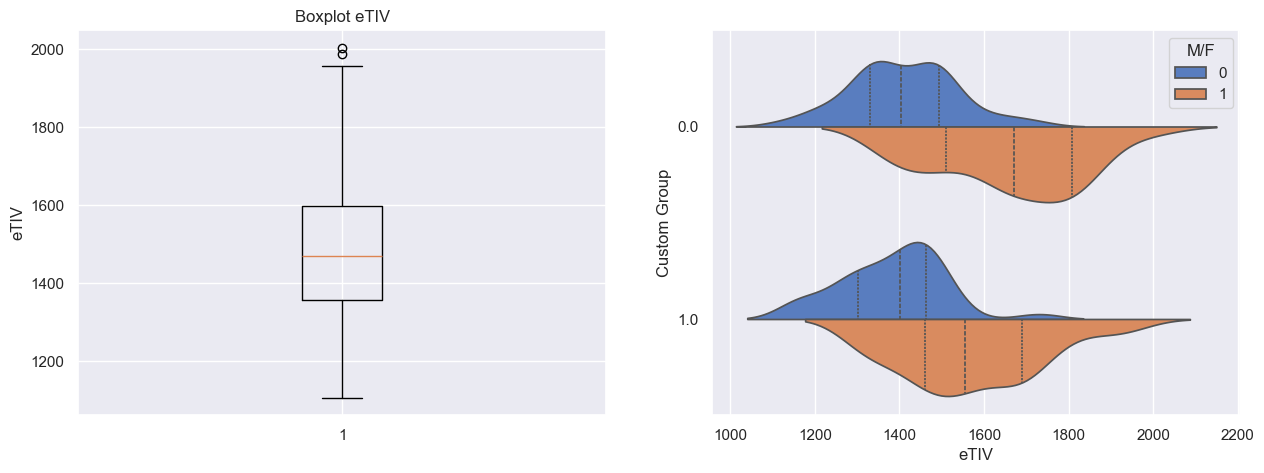

In [71]:
plt.subplot(1,2,1)
plt.boxplot(X_vis.eTIV)
plt.title('Boxplot eTIV')
plt.ylabel('eTIV')

plt.subplot(1,2,2)
sns.violinplot(x="eTIV", y="Custom Group",hue="M/F" ,orient="h", data=X_vis, palette="muted", split=True, inner="quartile")
plt.show()

Iz boxplota je vidljivo da ova značajka nema mnogo stršećoh vrijednosti - radi se o 2 primjera i oni ne odskaču toliko od ostatka skupa. S obzirom da se radi o značajki koja procjenjuje intrakranijalni volumen validna je pretpostavka da ti podaci nisu rezultat šuma u podacima ili krivo unesenih podataka prilikom formiranja skupa podataka.

Gornji prikaz upućuje na to da muškarci općenito imaju veći intrakranijalni volumen što je u skladu s istraživanjima iz područja biomedicine.  
Gornji graf ukazuje i na činjenicu da muškarci kojima je dijagnosticirana Alzheimerova bolest imaju manji intrakranijalni volumen od muškaraca kojima nije dijagnosticirana Alzheimerova bolest.

Normalizirani volumen mozga (nWBV)

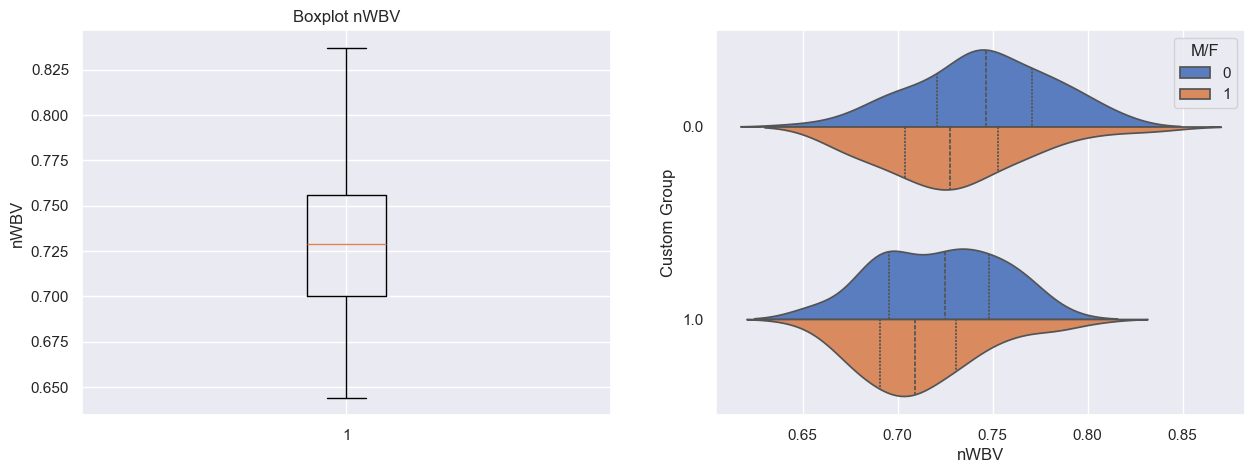

In [72]:
plt.subplot(1,2,1)
plt.boxplot(X_vis.nWBV)
plt.title('Boxplot nWBV')
plt.ylabel('nWBV')

plt.subplot(1,2,2)
sns.violinplot(x="nWBV", y="Custom Group",hue="M/F" ,orient="h", data=X_vis, palette="muted", split=True, inner="quartile")
plt.show()

Iz boxplota vidimo da ova značajka nema stršećih vrijednosti.  
Iz violinskog prikaza značajke nWBV vidljivo je da grupa ljudi kojima nije dijagnosticirana Alzheimerova bolest imaju veću vrijednost ove značajke. Drugim riječima ljudi koji nemaju dijagnosticiranu Alzheimerovu bolest imaju veći volumen mozga. Ovo proizlazi iz načina na koji Alzheimerova bolest napada stanice mozga.  

Atlas skalirajući faktor (ASF)

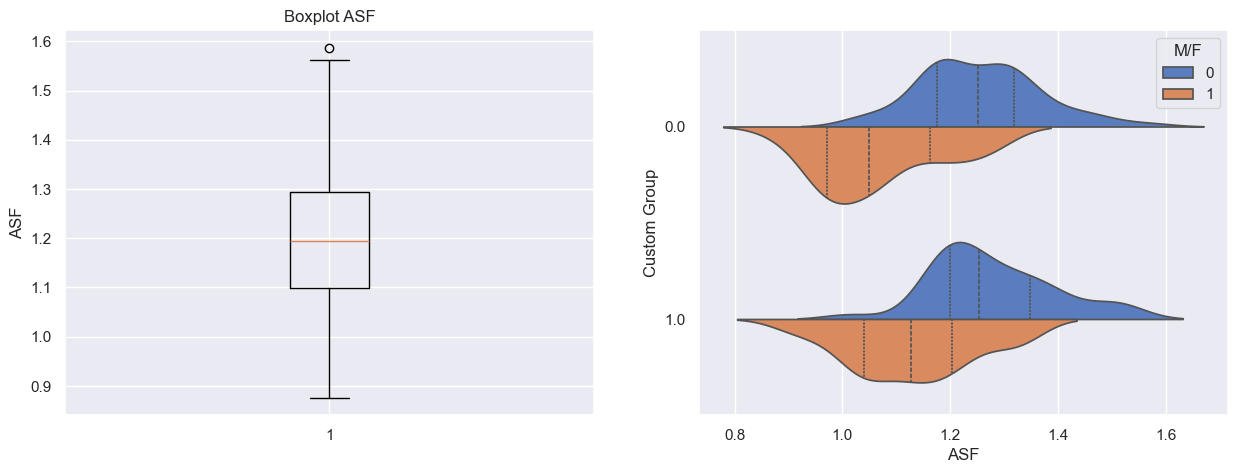

In [78]:
plt.subplot(1,2,1)
plt.boxplot(X_vis.ASF)
plt.title('Boxplot ASF')
plt.ylabel('ASF')

plt.subplot(1,2,2)
sns.violinplot(x="ASF", y="Custom Group",hue="M/F" ,orient="h", data=X_vis, palette="muted", split=True, inner="quartile")
plt.show()

Iz boxplota vidljivo je da u skupu podataka postoji jedna stršeća vrijednost, ali budući da ne odskače previše od ostalih vrijednosti možemo pretpostaviti da ta stršeća vrijednost nije rezultat šuma ili krivo unesenih podataka.  

Gornji prikaz upućuje na to da grupa kojoj je dijagnosticirana Alzheimerova bolest i grupa kojoj nije dijagnosticirana bolest imaju podjednak ASF.  
Također može se naslutiti da žene imaju veću vrijednost ASF od muškaraca

### 2. Proširenja

#### 2.1. Odabir značajki

##### 2.1.1. Korelacija

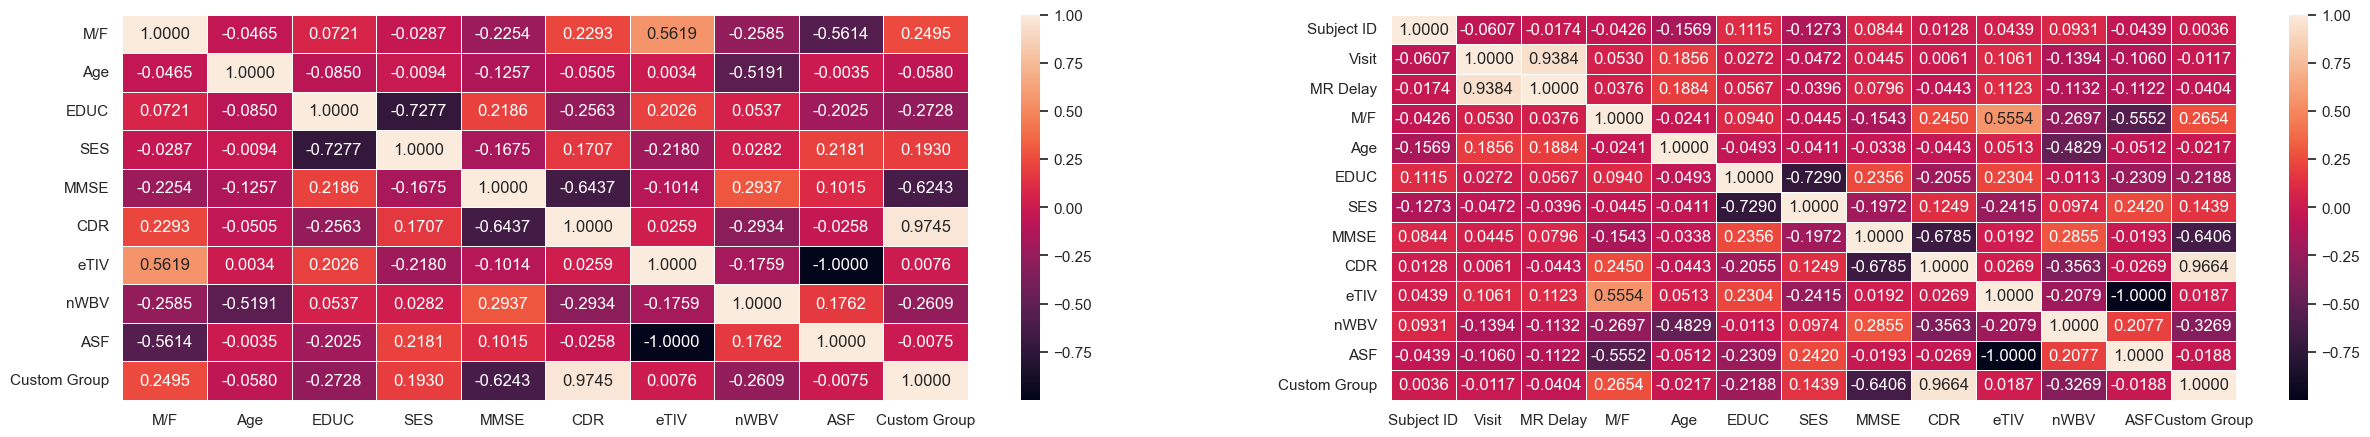

In [95]:
plt.figure(figsize=(30, 5))


plt.subplot(1,2,1)
corr_matrix = X_firstScan.corr(method='spearman')
sns.set(rc={'figure.figsize':(15,5)})
sns.heatmap(corr_matrix, annot=True, fmt=".4f", linewidths=0.5)


plt.subplot(1,2,2)
corr_matrix = X_allscans.corr(method='spearman')
sns.set(rc={'figure.figsize':(15,5)})
sns.heatmap(corr_matrix, annot=True, fmt=".4f", linewidths=0.5)
plt.show()

Iz korelacijske matrice za skup podataka samo sa prvim snimkama vidljivo je da su snažno korelirani sljedeći parovi varijabli:
- EDUC i SES
- MMSE i CDR
- CDR i Custom Group
- eTIV i ASF

Iz korelacijske matrice za skup podataka sa svim snimkama vidljivo je da su snažno korelirani sljedeći parovi varijabli: 
- EDUC i SES
- Visit i MR Delay
- MMSE i CDR
- CDR i Custom Group
- eTIV i ASF

##### 2.1.2. Informacijska dobit

In [84]:
# Function to calculate entropy
def entropy(class_probs):
    return -np.sum(class_probs * np.log2(class_probs))

# Function to calculate information gain
def information_gain(data, feature_name, target_name):
    total_entropy = entropy(data[target_name].value_counts(normalize=True))

    # Calculate weighted average entropy for the feature
    weighted_feature_entropy = 0
    for value in data[feature_name].unique():
        subset = data[data[feature_name] == value]
        value_prob = len(subset) / len(data)
        value_entropy = entropy(subset[target_name].value_counts(normalize=True))
        weighted_feature_entropy += value_prob * value_entropy

    # Calculate information gain
    info_gain = total_entropy - weighted_feature_entropy
    return info_gain


Informacijska dobit za skup podataka samo sa prvim snimkama

In [96]:
target_column = 'Custom Group' 
information_gains = {}

# Calculate information gain for each feature
for column in X_firstScan.columns:
    if column != target_column:
        information_gains[column] = information_gain(X_firstScan, column, target_column)

# Print information gains for each feature
print("Information Gains (predicting Custom Group) for first scans:")
for feature, gain in information_gains.items():
    print(f"{feature:>20}: {gain:.4f}")

Information Gains (predicting Custom Group) for first scans:
                 M/F: 0.0451
                 Age: 0.2346
                EDUC: 0.1009
                 SES: 0.0341
                MMSE: 0.4526
                 CDR: 0.9871
                eTIV: 0.8704
                nWBV: 0.5722
                 ASF: 0.8671


Informacijska dobit za skup podataka sa svim snimkama

In [97]:
target_column = 'Custom Group' 
information_gains = {}

# Calculate information gain for each feature
for column in X_allscans.columns:
    if column != target_column:
        information_gains[column] = information_gain(X_allscans, column, target_column)

# Print information gains for each feature
print("Information Gains (predicting Custom Group) for all scans:")
for feature, gain in information_gains.items():
    print(f"{feature:>20}: {gain:.4f}")

Information Gains (predicting Custom Group) for all scans:
          Subject ID: 0.8845
               Visit: 0.0053
            MR Delay: 0.5288
                 M/F: 0.0512
                 Age: 0.0759
                EDUC: 0.0918
                 SES: 0.0365
                MMSE: 0.4053
                 CDR: 0.9921
                eTIV: 0.7801
                nWBV: 0.4221
                 ASF: 0.7293


S obzirom na dobivene korelacije i informacijske dobiti prilikom treniranja modela koristit će se značajke: 
- M/F 
- Age
- EDUC
- SES
- MMSE
- eTIV
- nWBV

za skup podataka sa samo prvim snimkama te značajke:
- MR Delay
- M/F
- Age
- EDUC
- SES
- MMSE
- eTIV
- nWBV

Značajku CDR ne koristimo jer smo pomoću nje konstruirali oznaku 'Custom Group'. I dalje postoji korelacija u navedenim značajkama u oba skupa između značajki EDUC i SES. Njihovu korelaciju interpretiramo kao nešto što proizlazi iz stvarnog svijeta pa nećemo niti jednu od te dvije varijable micati iz skupa značajki. Od svih ostalih parova značajki odabrali smo jednu značajku i ostavili je u skupu.

